# Mini Project 2

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**


###  Hypothesis Testing of Standard Assumptions Theoretical Financial Mathematics

In the theory of mathematical finance, it is common to assume the log returns of a stock/index are normally distributed.


Investigate if the log returns of stocks or indexes of your choosing are normally distributed. Some suggestions for exploration include:

    1) Test if there are period of times when the log-returns of a stock/index have evidence of normal distribution.
    
    2) Test if removing extremal return data creates a distribution with evidence of being normal.
    
    3) Create a personalized portfolio of stocks with historical log return data that is normally distributed.
    
    4) Test if the portfolio you created in the first mini-project has significant periods of time with evidence of normally distributed log returns.
    
    5) Gather x-number of historical stock data and just perform a normality test on their log return data to see if any of the stocks exhibit evidence of log returns that are normally distributed.

In [1]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import datetime as dt
sns.set_style('darkgrid')

##### Problem 1

Let's consider Nasdaq index for the last 10 years

In [2]:
start_date = dt.datetime.today()-dt.timedelta(days = 365)
end_date = dt.datetime.today()

ndx = yf.download("^NDX", start="2015-01-01", end="2025-04-30")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
ndx.head()

Price,Close,High,Low,Open,Volume
Ticker,^NDX,^NDX,^NDX,^NDX,^NDX
Date,,,,,
2015-01-02,4230.240234,4276.709961,4206.459961,4258.600098,1435150000
2015-01-05,4160.959961,4210.959961,4151.850098,4206.549805,1794470000
2015-01-06,4110.830078,4176.259766,4090.330078,4174.779785,2167320000
2015-01-07,4160.000000,4169.970215,4126.390137,4139.850098,1957950000
2015-01-08,4240.549805,4247.930176,4192.629883,4195.490234,2105450000


In [4]:
#computing normalized returns
close = ndx['Close']
normalized_returns = close/close.iloc[0]-1

normalized_returns.columns = pd.MultiIndex.from_product([['Cumulative Return'], normalized_returns.columns])

ndx = pd.concat([ndx, normalized_returns], axis =1 )

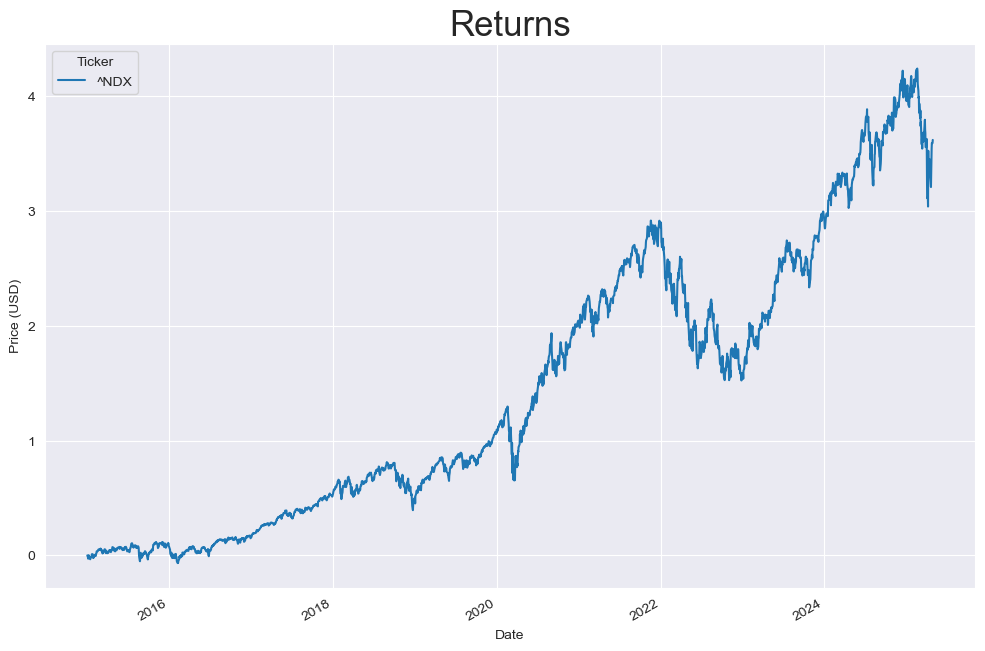

In [5]:
ndx['Cumulative Return'].plot(figsize = (12,8))
plt.title(f'Returns', size = 25)
plt.ylabel('Price (USD)')
plt.show()

In [6]:
#computing log returns
nasdaq_log_returns = np.log(ndx['Close']/ndx['Close'].shift(1))
nasdaq_log_returns = nasdaq_log_returns.dropna()

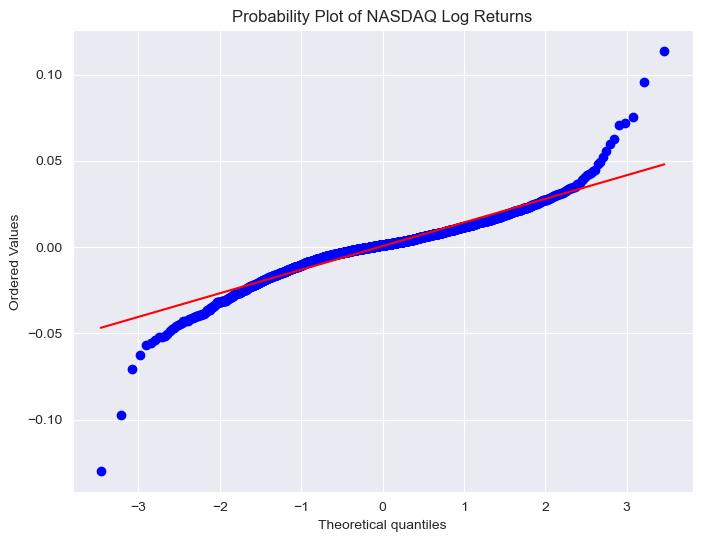

In [7]:
plt.figure(figsize=(8, 6))
stats.probplot(nasdaq_log_returns.squeeze(), dist="norm", plot=plt)
plt.title("Probability Plot of NASDAQ Log Returns", fontsize=12)
plt.show()



In [8]:
#testing if log returns have normal distribution
p = stats.normaltest(nasdaq_log_returns)[1]
if p < 0.05:
    print("→ Statistically significant evidence that the data is NOT normally distributed.")
else:
    print("→ No statistically significant evidence against normality.")

→ Statistically significant evidence that the data is NOT normally distributed.


Let's identify periods of normal distributions using rolling window.


In [9]:
ndx = yf.download("^NDX", start="2015-01-01", end="2025-04-30")

close = ndx['Close']
normalized_returns = close/close.iloc[0]-1

normalized_returns.columns = pd.MultiIndex.from_product([['Cumulative Return'], normalized_returns.columns])

ndx = pd.concat([ndx, normalized_returns], axis =1 )

nasdaq_log_returns = np.log(ndx['Close']/ndx['Close'].shift(1))
nasdaq_log_returns = nasdaq_log_returns.dropna()

[*********************100%***********************]  1 of 1 completed


Period from 2015-01-05 to 2015-07-06
→ No statistically significant evidence against normality.
----------------------------------------
Period from 2015-04-07 to 2015-10-02
→ Statistically significant evidence that the data is NOT normally distributed.
----------------------------------------
Period from 2015-07-07 to 2016-01-04
→ Statistically significant evidence that the data is NOT normally distributed.
----------------------------------------
Period from 2015-10-05 to 2016-04-05
→ No statistically significant evidence against normality.
----------------------------------------
Period from 2016-01-05 to 2016-07-05
→ Statistically significant evidence that the data is NOT normally distributed.
----------------------------------------
Period from 2016-04-06 to 2016-10-03
→ Statistically significant evidence that the data is NOT normally distributed.
----------------------------------------
Period from 2016-07-06 to 2017-01-03
→ Statistically significant evidence that the data is NOT

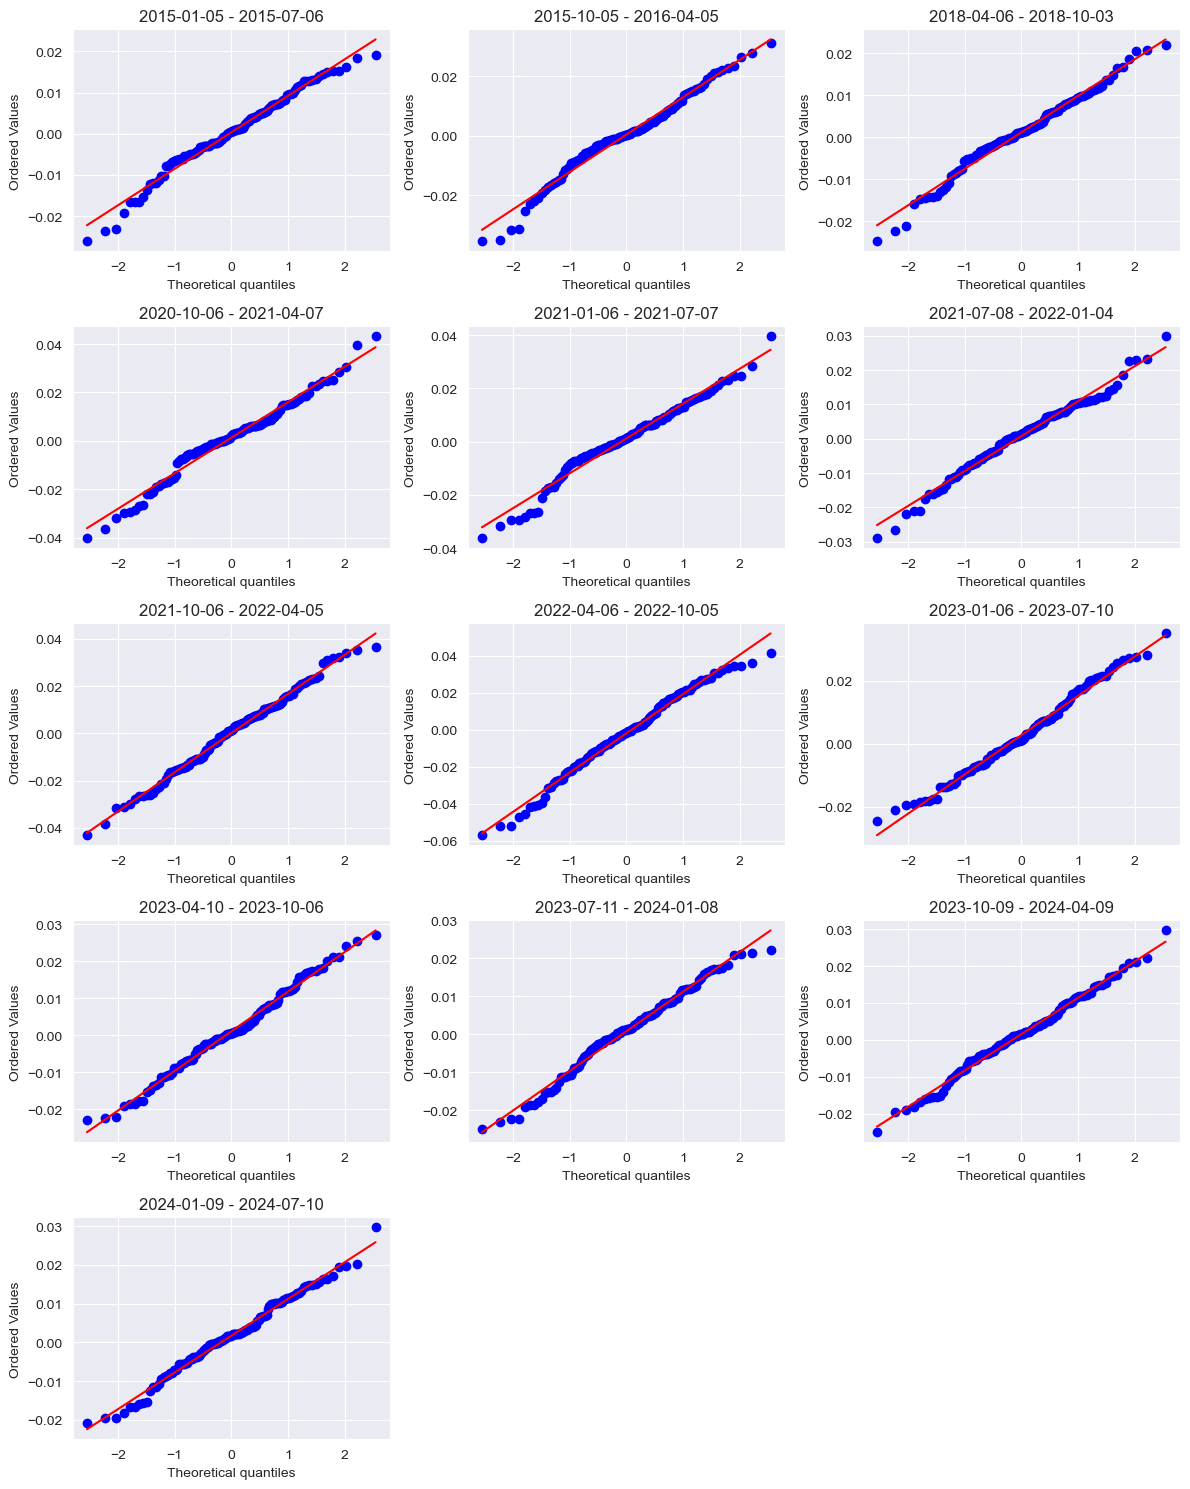

In [10]:
#period of the rolling window is 6 month, step is 3 month
window_size  = 126
step_size = 63

rolling_res = []
normal_periods = []
for i in range(0, len(nasdaq_log_returns) - window_size, step_size):
    window_data = nasdaq_log_returns.iloc[i:i+window_size]
    start_date = window_data.index[0].strftime('%Y-%m-%d')
    end_date = window_data.index[-1].strftime('%Y-%m-%d')

    p = stats.normaltest(window_data)[1]
    print(f"Period from {start_date} to {end_date}")
    if p < 0.05:
        print("→ Statistically significant evidence that the data is NOT normally distributed.")
    else:
        print("→ No statistically significant evidence against normality.")
        normal_periods.append(window_data)
    print("----------"*4)

#Display normal periods
N = len(normal_periods)
ncols = 3
nrows = (N + ncols - 1) // ncols 
#plot found periods against normal distribution                              
fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows))
axes = axes.flatten()

for ax, w in zip(axes, normal_periods):
    stats.probplot(w.squeeze(), dist="norm", plot=ax)
    ax.set_title(f"{w.index[0].strftime('%Y-%m-%d')} - {w.index[-1].strftime('%Y-%m-%d')}")

for ax in axes[len(normal_periods):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()


### Problem 2

Let's try to find extremal periods. We will try to find days that diverge by 1, 2 or 3 sigmas from the mean. After that we will try to exclude them and test for normality.

In [11]:
#finding mean log return
mean_log_return = np.mean(nasdaq_log_returns)
mean_log_return

0.000589771913922419

In [12]:
returns = nasdaq_log_returns['^NDX']

std_dev = returns.std()
#finding values that diverge from mean > 1sigma, 2sigma, 3sigma.
one_sigma_mask = abs(returns - mean_log_return) > 1*std_dev
two_sigma_mask = abs(returns - mean_log_return) > 2*std_dev
three_sigma_mask = abs(returns - mean_log_return) > 3*std_dev

one_sigma_dates = returns[one_sigma_mask].index.tolist()
two_sigma_dates = returns[two_sigma_mask].index.tolist()
three_sigma_dates = returns[three_sigma_mask].index.tolist()

one_sigma_values = returns[one_sigma_mask].tolist()
two_sigma_values = returns[two_sigma_mask].tolist()
three_sigma_values = returns[three_sigma_mask].tolist()

print(f"Number of 1-sigma outliers: {len(one_sigma_dates)}")
print(f"Number of 2-sigma outliers: {len(two_sigma_dates)}")
print(f"Number of 3-sigma outliers: {len(three_sigma_dates)}")


Number of 1-sigma outliers: 594
Number of 2-sigma outliers: 135
Number of 3-sigma outliers: 35


In [13]:
normal_1_mask = abs(returns - mean_log_return) <= 1*std_dev
normal_2_mask = abs(returns - mean_log_return) <= 2*std_dev
normal_3_mask = abs(returns - mean_log_return) <= 3*std_dev
#retuns that don't diverge from mean more than 1sigma, 2sigma, 3sigma.
normal_1_returns = returns[normal_1_mask]
normal_2_returns = returns[normal_2_mask]
normal_3_returns = returns[normal_3_mask]

p_1 = stats.normaltest(normal_1_returns)[1]
print("1 sigma")
if p_1 < 0.05:
    print("→ Statistically significant evidence that the data is NOT normally distributed.")
else:
    print("→ No statistically significant evidence against normality.")
    
print("--------"*4)

p_2 = stats.normaltest(normal_2_returns)[1]
print("2 sigma")
if p_2 < 0.05:
    print("→ Statistically significant evidence that the data is NOT normally distributed.")
else:
    print("→ No statistically significant evidence against normality.")
    
print("--------"*4)
print("3 sigma")

p_3 = stats.normaltest(normal_3_returns)[1]
if p_3 < 0.05:
    print("→ Statistically significant evidence that the data is NOT normally distributed.")
else:
    print("→ No statistically significant evidence against normality.")

1 sigma
→ Statistically significant evidence that the data is NOT normally distributed.
--------------------------------
2 sigma
→ Statistically significant evidence that the data is NOT normally distributed.
--------------------------------
3 sigma
→ Statistically significant evidence that the data is NOT normally distributed.


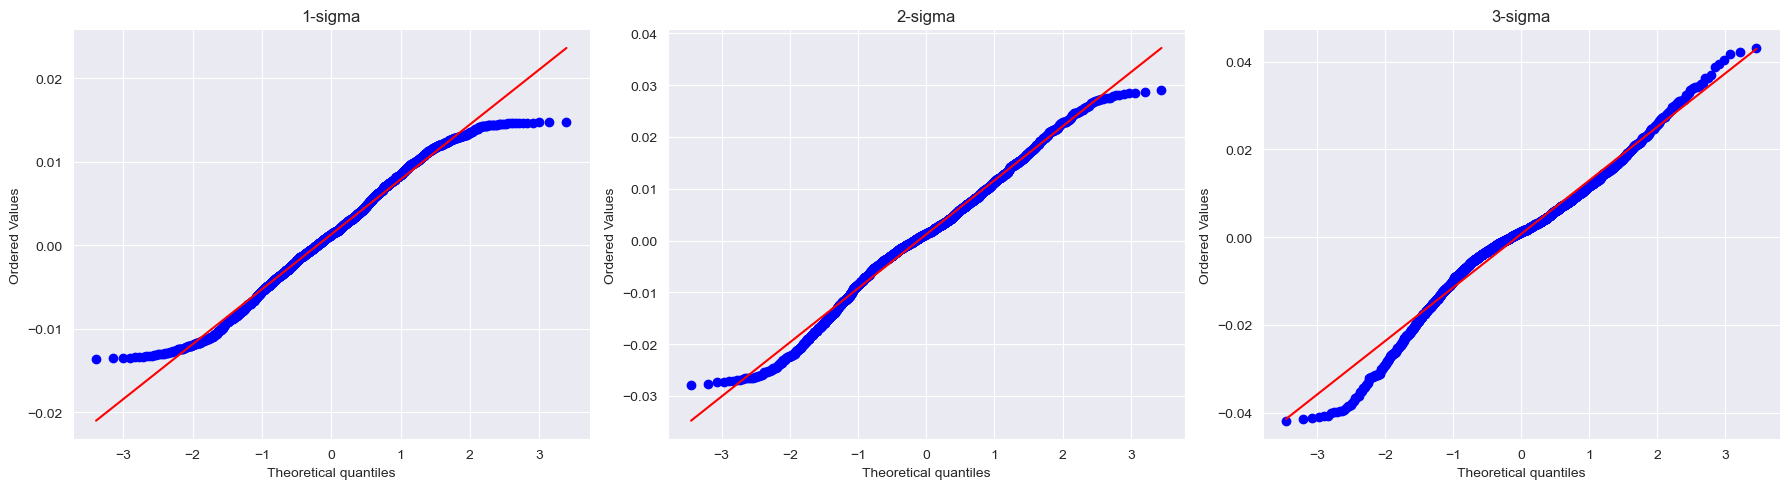

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, data, label in zip(axes,
                           [normal_1_returns,
                            normal_2_returns,
                            normal_3_returns],
                           ["1-sigma", "2-sigma", "3-sigma"]):

    stats.probplot(data.squeeze(), dist="norm", plot=ax)
    ax.set_title(label, fontsize=12)

plt.tight_layout()
plt.show()


In [15]:
from scipy.optimize import minimize

#### Problem 3



In [16]:
#take some stocks
stocks = ['TSLA', 'NVDA', 'COIN', 'PLTR', 'ROKU', 'AMD', 'JNJ', 'PG', 'KO', 'VZ', 'WMT', 
           'MSFT', 'GOOGL', 'AAPL', 'HD', 'LOW', 'XOM', 'CVX', 'FCX', 'NEM', 'JPM', 'CAT',
          'ASML', 'TSM', 'BABA', 'SHOP', 'NVO', 'TM', 'SONY', 'BHP', 'UL',
          'NFLX',   'ZM',   'UBER',   'SPOT',   'BYND',   'MRNA', 'ARKK', 'RBLX',
          'NEE',   'MMM',   'MCD',   'DIS',   'PFE', 'T',]

portfolio_data = yf.download(stocks, start='2019-01-01', end='2025-01-01')

portfolio_log_returns = np.log(portfolio_data['Close']/portfolio_data['Close'].shift(1))
portfolio_log_returns = portfolio_log_returns.dropna()

[*********************100%***********************]  45 of 45 completed


In [17]:
def normality_objective(weights, returns_matrix):
    """Objective function: minimize departures from normality"""
    portfolio_returns = (returns_matrix * weights).sum(axis=1)
    
    jb_stat, _ = stats.jarque_bera(portfolio_returns)
    return jb_stat

constraints = ({'type': 'eq', 'fun': lambda w: w.sum() - 1})
bounds = [(0, 1) for _ in range(len(stocks))]

# Initial guess: equal weights
initial_weights = np.array([1/len(stocks)] * len(stocks))

# Optimize
result = minimize(normality_objective, initial_weights, 
                 args=(portfolio_log_returns,), 
                 method='SLSQP', bounds=bounds, constraints=constraints)

optimal_weights = result.x
optimized_portfolio_returns = (portfolio_log_returns * optimal_weights).sum(axis=1)

In [18]:
# Check optimization success
print("="*50)
print("OPTIMIZATION RESULTS")
print("="*50)
print(f"Optimization successful: {result.success}")
print(f"Final objective value (Jarque-Bera statistic): {result.fun:.4f}")
print(f"Number of iterations: {result.nit}")
print(f"Optimization message: {result.message}")

OPTIMIZATION RESULTS
Optimization successful: True
Final objective value (Jarque-Bera statistic): 2.1127
Number of iterations: 23
Optimization message: Optimization terminated successfully


In [19]:
optimal_weights

array([2.66637591e-14, 4.45831221e-13, 2.17613119e-13, 3.98691149e-13,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.42605562e-14,
       1.40275408e-01, 0.00000000e+00, 0.00000000e+00, 2.64333256e-01,
       1.29777080e-13, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.70205570e-01,
       1.56225499e-01, 1.48174457e-13, 0.00000000e+00, 1.19532854e-01,
       2.27269213e-13, 5.87869773e-13, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 7.52766015e-02, 2.02827294e-13,
       5.24214816e-13, 1.97166429e-14, 2.56119011e-13, 0.00000000e+00,
       0.00000000e+00, 3.15682549e-13, 1.56027515e-13, 1.86435438e-13,
       0.00000000e+00, 7.41508099e-02, 4.20943494e-13, 0.00000000e+00,
       8.05098057e-14])

In [20]:
portfolio_log_returns_optimized = (portfolio_log_returns * optimal_weights).sum(axis=1)


In [21]:
p = stats.normaltest(portfolio_log_returns_optimized)[1]

if p < 0.05:
    print("→ Statistically significant evidence that the data is NOT normally distributed.")
else:
    print("→ No statistically significant evidence against normality.")

→ No statistically significant evidence against normality.


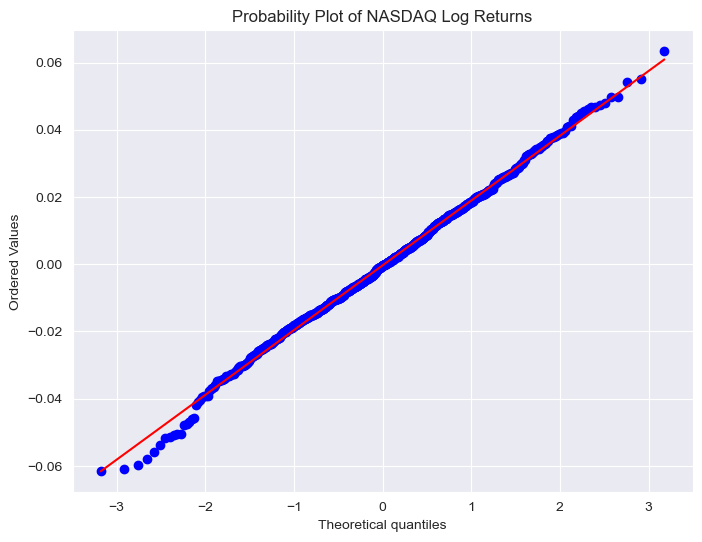

In [22]:
plt.figure(figsize=(8, 6))
stats.probplot(portfolio_log_returns_optimized.squeeze(), dist="norm", plot=plt)
plt.title("Probability Plot of NASDAQ Log Returns", fontsize=12)
plt.show()


Text(0.5, 1.0, 'Portfolio Performance')

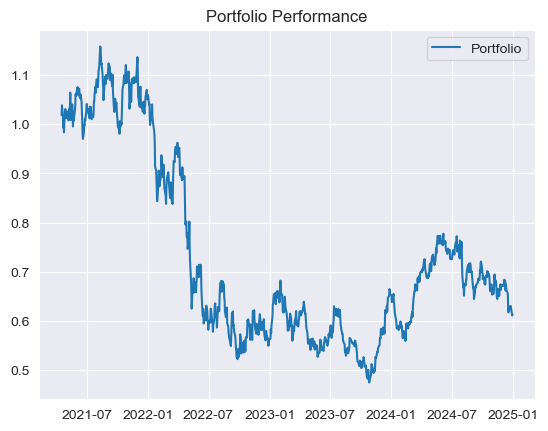

In [23]:

# Plot cumulative performance
cumulative = (1 + portfolio_log_returns_optimized).cumprod()

plt.plot(cumulative, label='Portfolio')
plt.legend()
plt.title('Portfolio Performance')

## Problem 4

We copy the code from the first project and then check the portfolios for normality.
We see that their volatility is not normally distributed.

In [24]:
from scipy.optimize import minimize

high_volatility_tickers = ['AMD', 'BYND', 'COIN', 'MRNA', 'NVDA', 'PLTR', 'ROKU', 'SHOP', 'TSLA']
low_volatility_tickers = ['BHP', 'CVX', 'HD', 'JNJ', 'JPM', 'KO', 'LOW', 'MCD', 'MSFT', 'NEE', 'PFE', 'PG', 'T', 'UL', 'VZ', 'WMT', 'XOM']

start_date = dt.datetime.today()-dt.timedelta(days = 365)
end_date = dt.datetime.today()

low_volatility_stock = yf.download(low_volatility_tickers, start = start_date, end =end_date)

close = low_volatility_stock['Close']
low_normalized_returns = close/close.iloc[0]-1

low_normalized_returns.columns = pd.MultiIndex.from_product([['Cumulative Return'], low_normalized_returns.columns])

low_volatility_stock = pd.concat([low_volatility_stock, low_normalized_returns], axis =1 )

high_volatility_stock = yf.download(high_volatility_tickers, start = start_date, end =end_date)

high_close = high_volatility_stock['Close']
high_normalized_returns = close/close.iloc[0]-1

high_normalized_returns.columns = pd.MultiIndex.from_product([['Cumulative Return'], high_normalized_returns.columns])

high_volatility_stock = pd.concat([high_volatility_stock, high_normalized_returns], axis =1 )

low_daily_log_returns = np.log(low_volatility_stock['Close']/low_volatility_stock['Close'].shift(1))
low_daily_log_returns = low_daily_log_returns.dropna()

high_daily_log_returns = np.log(high_volatility_stock['Close']/high_volatility_stock['Close'].shift(1))
high_daily_log_returns = high_daily_log_returns.dropna()

high_covariance_matrix = 252*((high_daily_log_returns[high_volatility_tickers]).cov())
low_covariance_matrix = 252*((low_daily_log_returns[low_volatility_tickers]).cov())

[*********************100%***********************]  17 of 17 completed
[*********************100%***********************]  9 of 9 completed


In [25]:
n_low = len(low_volatility_tickers)
n_high = len(high_volatility_tickers)

low_initial_weights = np.array([1/n_low] * n_low)
high_initial_weights = np.array([1/n_high] * n_high)

constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights)-1}, {'type': 'ineq', 'fun': lambda weights: min(weights)-.0})

def portfolio_volatility(weights, mat):
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(mat, weights)))
    return portfolio_std_dev

low_res = minimize(portfolio_volatility, low_initial_weights, args=(low_covariance_matrix,), constraints=constraints)

low_optimal_weights = low_res.x

# Print the optimal weights and expected returns
print("Low risk:")
for ticker, weight in zip(low_volatility_tickers, low_optimal_weights):
    print(f"{ticker}: Weight = {weight:.4f}")
    
print(f' The optimal volatility subject to the constraints is {low_res.fun}')
print("-----"*20)
print("-----"*20)


high_res = minimize(portfolio_volatility, high_initial_weights, args=(high_covariance_matrix,), constraints=constraints)

high_optimal_weights = high_res.x
print("High risk")
for ticker, weight in zip(high_volatility_tickers, high_optimal_weights):
    print(f"{ticker}: Weight = {weight:.4f}")
    
print(f' The optimal volatility subject to the constraints is {high_res.fun}')
print("-----"*20)
print("-----"*20)

Low risk:
BHP: Weight = -0.0000
CVX: Weight = 0.0001
HD: Weight = 0.0302
JNJ: Weight = 0.1741
JPM: Weight = 0.0036
KO: Weight = 0.1689
LOW: Weight = 0.0000
MCD: Weight = 0.0705
MSFT: Weight = 0.2125
NEE: Weight = -0.0000
PFE: Weight = 0.0000
PG: Weight = 0.0368
T: Weight = 0.0559
UL: Weight = 0.1148
VZ: Weight = 0.0187
WMT: Weight = 0.0098
XOM: Weight = 0.1042
 The optimal volatility subject to the constraints is 0.11716782134491503
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
High risk
AMD: Weight = 0.2247
BYND: Weight = 0.1836
COIN: Weight = 0.0000
MRNA: Weight = 0.1608
NVDA: Weight = 0.1558
PLTR: Weight = 0.0492
ROKU: Weight = 0.1010
SHOP: Weight = 0.1119
TSLA: Weight = 0.0131
 The optimal volatility subject to the constraints is 0.4286014511482924
---------------------------------------------------------------------------------

In [26]:
low_log_returns_optimized = (low_daily_log_returns*low_optimal_weights).sum(axis = 1)
high_log_returns_optimized = (high_daily_log_returns*high_optimal_weights).sum(axis = 1)

p_low = stats.normaltest(low_log_returns_optimized)[1]
p_high = stats.normaltest(high_log_returns_optimized)[1] 
print("Low risk portfolio")
if p_low < 0.05:
    print("→ Statistically significant evidence that the data is NOT normally distributed.")
else:
    print("→ No statistically significant evidence against normality.")
    
print("--------"*20)
print("High risk portfolio")
if p_high < 0.05:
    print("→ Statistically significant evidence that the data is NOT normally distributed.")
else:
    print("→ No statistically significant evidence against normality.")

Low risk portfolio
→ Statistically significant evidence that the data is NOT normally distributed.
----------------------------------------------------------------------------------------------------------------------------------------------------------------
High risk portfolio
→ Statistically significant evidence that the data is NOT normally distributed.


## Problem 5
We take stocks from problem 3 and check whether their volatilities normally distributed.
As we can see below, all of them are not normally distributed.

TSLA shows statistically significant evidence that the data is NOT normally distributed.
------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
NVDA shows statistically significant evidence that the data is NOT normally distributed.
------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
COIN shows statistically significant evidence that the data is NOT normally distributed.
------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------
PLTR sh

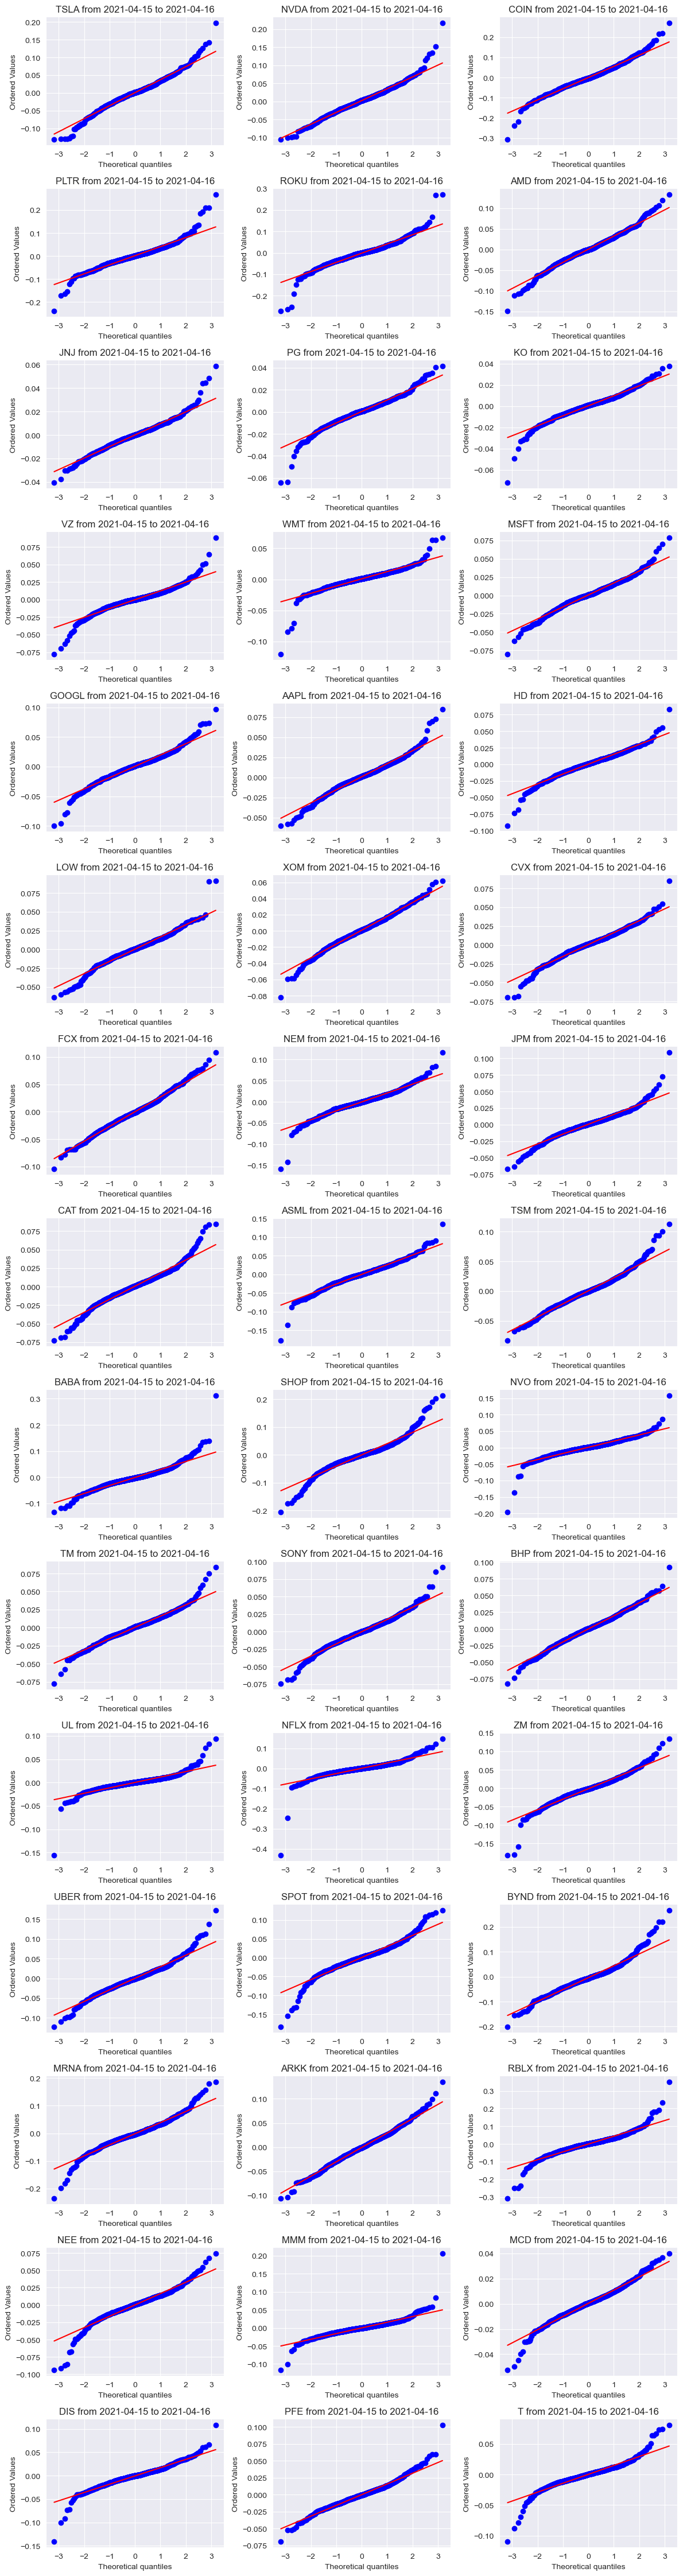

In [27]:
for i in stocks:
    p_i = stats.normaltest(portfolio_log_returns[i])[1]

    if p_i < 0.05:
        print(f"{i} shows statistically significant evidence that the data is NOT normally distributed.")
    else:
        print(f"{i} shows No statistically significant evidence against normality.")
    print("----"*30)
    print("----"*30)
    #plt.figure(figsize=(8, 6))
    #stats.probplot(portfolio_log_returns[i].squeeze(), dist="norm", plot=plt)
    #plt.title(f"Probability Plot of {i} Log Returns", fontsize=12)
    #plt.show()
N = len(stocks)
ncols = 3
nrows = (N + ncols - 1) // ncols 
                              
fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows))
axes = axes.flatten()

for ax, i in zip(axes, stocks):
    stats.probplot(portfolio_log_returns[i].squeeze(), dist="norm", plot=ax)
    ax.set_title(f"{i} from {portfolio_log_returns[i].index[0].strftime('%Y-%m-%d')} to {portfolio_log_returns[i].index[1].strftime('%Y-%m-%d')}")

for ax in axes[len(stocks):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()
    
    